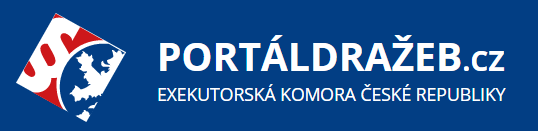

### Dynamic scraper
#### Goal
As the title suggests, the first section incorporates a data scraper. Its goal is to crawl through https://www.portaldrazeb.cz and to collect actual data about auctions and auctioneers. It also scrapes lists of all possible auction attributes which we will subsequently use to filter the auctions with respect to location, type, etc.  
#### Problem
The problem is that the webpage has a dynamic content and therefore we cannot easily extract the "static" source code as in other cases. The website also does not provide API (it actually does, however, not for us and not for the purposes we need). 
#### Solution
We use methods that handle the dynamic content - our solution is the installation of package *selenium* and setting up a *Google Chrome webdriver*. We basically open the webpage, collect its source code and navigate between pages. Thanks to this package (and the webdriver which is also included in the GitHub repository) we manage to download all the data we need. More detailed description of particular methods can be found in the class docstring and in the comments.

In [1]:
# importing the class which will do the scraping  
from dynamic_scraper import DataDownloader
down = DataDownloader() # initialising the scraper

Downloader successfully initialized!
 

    This class crawls through dynamic content of https://www.portaldrazeb.cz and collects following things:

            1) soup object for every auctioneer
            2) link to every auction + auction category (since the category is not within the auction page itself)
            3) list of all possible values from drop-down menu (auction categories, regions and districts)
    
    Subsequently it extracts soup objects of all auctions from the links collected in 2).
    


In [2]:
# links we will need
url_auctions = 'https://www.portaldrazeb.cz/drazby/pripravovane'
url_auctioneers = 'https://www.portaldrazeb.cz/drazebnici'

The next lines of code will scrape the data. Please do not interact with the Google Chrome window that will open in the background, just wait until it does its job and closes. The whole procedure should take a bit over 20 minutes. 

In [3]:
down.get_soups_of_auctioneers(url_auctioneers) # takes approx. 1 minute

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:42<00:00,  5.28s/it]

Soup objects of auctioneers successfully downloaded! There are 158 of them right now.


In [4]:
down.get_auction_links_and_categories(url_auctions) # takes approx. 5 minutes

100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [05:02<00:00,  5.40s/it]


Auction links and categories successfully downloaded! There are 1105 auctions right now.


In [5]:
down.get_items_from_dropdown_menu(url_auctions) 

Auction categories, regions and districts successfully downloaded!


In [6]:
down.extract_auction_soups() # takes approx. 17 minutes

100%|██████████████████████████████████████████████████████████████████████████████| 1105/1105 [12:53<00:00,  1.43it/s]

Soup objects successfully appended to auction_links_and_categories.


In [18]:
down.auctioneers_soups[0]

<article><div class="row"><div class="col-12-xl"><h2><a>Obvod: Benešov</a></h2> <div class="row auctioneer-about"><div class="col-4-xl col-12-xs"><ul><li><strong>Vychopňová Iva JUDr.</strong></li> <li><span>
                                                        Jiráskova
                                                        2042
                                                        </span> <!-- --></li> <li>256 01 Benešov</li></ul></div> <div class="col-4-xl col-12-xs"><ul><li><i class="fal fa-phone"></i> <a href="tel:311444834">311444834</a></li> <li><i class="fal fa-envelope"></i> <a href="mailto:info@eubenesov.cz">info@eubenesov.cz</a></li> <li><i class="fal fa-globe"></i> <a href="http://www.eubenesov.cz">http://www.eubenesov.cz</a></li></ul></div> <div class="col-4-xl col-12-xs"><ul><li><strong>Č. soud. exek.:</strong> 170</li> <li><strong>IČ:</strong> <span>
                                                            72552565
                                                

### Data processor
#### 

In [7]:
import pandas as pd
import numpy as np

In [8]:
czech = {'\\u00e1': 'á',"\\u010d":"č","\\u010f":"ď","\\u00e9":"é","\\u011b":"ě","\\u00ed":"í","\\u0148":"ň","\\u00f3":"ó","\\u0159":"ř","\\u0161":"š","\\u0165":"ť","\\u00fa":"ú","\\u016f":"ů","\\u00fd":"ý","\\u017e":"ž","\\u00c1":"Á","\\u00c4":"Ä","\\u010c":"Č","\\u010e":"Ď","\\u00c9":"É","\\u011a":"Ě","\\u00cd":"Í","\\u0147":"Ň","\\u00d3":"Ó","\\u0158":"Ř","\\u0160":"Š","\\u0164":"Ť","\\u00da":"Ú","\\u016e":"Ů","\\u00dd":"Ý","\\u017d":"Ž"}
#necessary to translate groups of characters from the source code to Czech characters

In [9]:
auctionslist=[]
for i in range(len(down.auction_links_and_categories)):
    soup = down.auction_links_and_categories[i][3]
    auctiondata=soup.findAll("div", {"class": "auction"})
    auctiondata=str(auctiondata[0])
    for x,y in czech.items():
        auctiondata = auctiondata.replace(x, y)#here the source-Czech dictionary is used
    auctiondata=auctiondata.replace('&quot;','"')
    #auctiondata=auctiondata.replace('"','')
    title=auctiondata[(auctiondata.index("title") + len("title")+3):]
    title=title[:title.index("category")-3]
    districtname=auctiondata[(auctiondata.index("district_name") + len("district_name")+3):(auctiondata.index("district_name") + len("district_name")+33)]
    districtname=districtname[:districtname.index('"')]
    if districtname=="' ')": districtname=np.nan#some auctions do not have this parameter, so it returns these characters
    regionname=auctiondata[(auctiondata.index("county_name")+ len("county_name")+3):(auctiondata.index("county_name")+ len("county_name")+33)]
    regionname=regionname[:regionname.index('"')]
    if regionname=="<th>Okres</th>\n<td v-text=":regionname=np.nan#like districtname, it is not everywhere
    auctioneer=auctiondata[(auctiondata.index("auctioneer_office") + len("auctioneer_office")+30):]
    auctioneer=auctioneer[:auctioneer.index("addresses")-3].split(" ") 
    number=auctiondata[(auctiondata.index('voluntary')-17):(auctiondata.index('voluntary')-3)].replace(':','').replace('"', '')
    estimated_price=auctiondata[(auctiondata.index("estimated_price") + len("estimated_price")+2):]
    estimated_price=estimated_price[:estimated_price.index("item_price")-2]
    reserve_price=auctiondata[auctiondata.index("item_price")+12:]
    reserve_price=reserve_price[:reserve_price.index("minimal_bid")-2]
    link = down.auction_links_and_categories[i][0]
    category = down.auction_links_and_categories[i][1][0]
    try: subcategory = down.auction_links_and_categories[i][1][1]
    except: subcategory = "-"
    
    auction=[]
    auction.extend([auctioneer[0],auctioneer[1],districtname,regionname,title,category,subcategory,number,estimated_price,reserve_price,link])
    
    auctionslist.append(auction)
    #print([i],sep=' ', end='', flush="true")writes how many auctions it processed, just to ensure it actually does something
    #takes a shitload of time to scrape it all(15 to 20 minutes, probably. The bottleneck is getting all those requests, so the only way to make it faster seems to be to buy better internet.)

In [10]:
auctions = pd.DataFrame(auctionslist)
auctions.columns = ["Surname","Name","District","Region","Title","Category","Subcategory","Code","Estimated_price","Reserve_price","Link"]
auctions.head()

,Surname,Name,District,Region,Title,Category,Subcategory,Code,Estimated_price,Reserve_price,Link
0,Schafferová,Jaroslava,Loukovec,Mladá Boleslav,Dražba podílů na pozemcích v obci Loukovec,Nemovitosti,Pozemek,98EX827/05-157,21500,14334,https://www.portaldrazeb.cz/drazba/198ex827-05...
1,Ivanko,Igor,NaN,Praha-východ,Elektronická dražba id. podílu o velikosti 1/9...,Nemovitosti,Pozemek,67EX902/13-617,6900,4600,https://www.portaldrazeb.cz/drazba/167ex902-13...
2,Smola,Erik,Strakonice,Jihočeský kraj,"Osobní automobil MERCEDES BENZ, model S",Movitosti,Auto-moto,r212EX18/21,210000,70000,https://www.portaldrazeb.cz/drazba/212ex18-21-...
3,Bednář,Richard,Teplice,Ústecký kraj,"Dražba pozemku v obci Bystřany, okres Teplice,...",Nemovitosti,Pozemek,003EX950/12,200000,133334,https://www.portaldrazeb.cz/drazba/003ex950-12...
4,Leskovjan,Jiří,Šumperk,Šumperk,byt v Šumperku,Nemovitosti,Byt,189DD16/21-08,2500000,1900000,https://www.portaldrazeb.cz/drazba/189dd16-21-...


In [23]:
auctions

,Surname,Name,District,Region,Title,Category,Subcategory,Estimated_price,Reserve_price,Link
Code,,,,,,,,,,
179DD2/21-6,Ráček,Zdeněk,NaN,NaN,VW passat VARIANT b6,Movitosti,Auto-moto,75000,75000,https://www.portaldrazeb.cz/drazba/179dd2-21-6...
083EX881/11-73,Souček,Kamil,Vysoké Veselí,Jičín,"podíl 3/5 RD, Vysoké Veselí",Nemovitosti,Rodinný dům,238600,159120,https://www.portaldrazeb.cz/drazba/083ex881-11...
er107DD4/21,Zálešák,Lubomír,Brno-venkov,Jihomoravský kraj,Pozemky v Moravských Bránicích - okr. Brno-venkov,Nemovitosti,Pozemek,120000,80000,https://www.portaldrazeb.cz/drazba/107dd4-21-1...
64EX4700/14-93,Svoboda,Jan,Olomouc,Olomoucký kraj,"Pozemek o velikosti 17534 m2, Moravská Loděnic...",Nemovitosti,Pozemek,36000,24000,https://www.portaldrazeb.cz/drazba/164ex4700-1...
139EX36243/14,Kubis,Marcel,Jalubí,Uherské Hradiště,"Dražba podílu id. 11/12 na v obci Jalubí, okr...",Nemovitosti,-,399000,266000,https://www.portaldrazeb.cz/drazba/139ex36243-...
...,...,...,...,...,...,...,...,...,...,...
158EX129/14,Bohutínský,Jan,Frýdek-Místek,Moravskoslezský kraj,Termín dražby není stanoven - 1/2 RD v Jablunk...,Nemovitosti,Rodinný dům,435000,290000,https://www.portaldrazeb.cz/drazba/158ex129-14...
083EX806/15-71,Souček,Kamil,Benešov,Středočeský kraj,"osobní automobil Škoda Octavia, TDi, 2012",Movitosti,Auto-moto,210000,0,https://www.portaldrazeb.cz/drazba/083ex806-15...
158EX1248/13,Bohutínský,Jan,Trutnov,Královéhradecký kraj,Termín dražby není stanoven 1/2 pohostinského ...,Nemovitosti,Rodinný dům,1750000,1166667,https://www.portaldrazeb.cz/drazba/158ex1248-1...


In [196]:
auctions.to_csv('auctionslist.csv')

In [31]:
!pip install pyshp

  Created wheel for pyshp: filename=pyshp-2.1.3-py3-none-any.whl size=37268 sha256=bcc4e4101679d70d4532f2b6273f605248d139ebfe721631f74944f16a68a455
  Stored in directory: c:\users\technician\appdata\local\pip\cache\wheels\1f\1b\b5\54affbefc8a7e2bdf1da000fc576b8a1c91338f1f327a04f4c
Successfully built pyshp


In [33]:
!pip install descartes

In [11]:
from descartes import PolygonPatch
import shapefile

In [12]:
import matplotlib.pyplot as plt

In [13]:
sf=shapefile.Reader('districts')

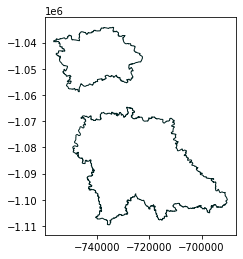

In [23]:
fig = plt.figure() 
ax = fig.gca()
for i in range(0,2):
    poly=sf.shape(i).__geo_interface__
    ax.add_patch(PolygonPatch(poly, fc='#ffffff', ec='#002222', alpha=1, zorder=2 ))
ax.axis('scaled')
plt.show()

In [15]:
?PolygonPatch